## lineqGPR: an R package for Gaussian process modelling with inequality constraints

---
OQUAIDO Scientific Meeting, November 26, 27 & 28 - 2019 <br>
Mines Saint-Etienne, France

In [1]:
library(lineqGPR)  # package GP regression under inequality constraints
library(repr)      # package for graphics and visualisation
library(gridExtra) # package for graphics and visualisation

Loading required package: nloptr
Loading required package: broom
Loading required package: tmg
Loading required package: mvtnorm
Loading required package: purrr


# General information

## Description
  *lineqGPR* is a package for Gaussian process interpolation, regression
  and simulation under linear inequality constraints based on
  (López-Lopera et al., 2018). Constrained models and constrained additive models
  are given as objects with "lineqGP" and "lineqAGP" S3 classes.
  Implementations according to (Maatouk and Bay, 2017) are also provided as objects
  with "lineqDGP" S3 class.
  
## Important functions or methods

| Function         | Description                                                              |
|------------------|--------------------------------------------------------------------------|
| **create**       | Creation function of GP models under linear inequality constraints.      |
| **augment**      | Augmentation of GP models according to local and covariance parameters.  |
| **lineqGPOptim** | Covariance parameter estimation via maximum likelihood.             |
| **predict**      | Prediction of the objective function at new points using a Kriging model.|
| **simulate**     | Simulation of kriging models under linear inequality constraints.        |
| **plot**	       | Plot for a constrained Kriging model.                                    |
| **ggplot**       | GGPlot for a constrained Kriging model.                                  |

## Warning
  *lineqGPR* may strongly evolve in the future in order to incorporate other
  packages for Gaussian process regression modelling (see, e.g., kergp,
  DiceKriging, DiceDesign). It could be also scaled to higher dimensions and
  for a large number of observations.

## Note
  *lineqGPR* was developed within the frame of the Chair in Applied
  Mathematics OQUAIDO, gathering partners in technological research (BRGM,
  CEA, IFPEN, IRSN, Safran, Storengy) and academia (CNRS, Ecole Centrale
  de Lyon, Mines Saint-Etienne, University of Grenoble, University of Nice,
  University of Toulouse) around advanced methods for Computer Experiments.

## References

  1. López-Lopera, A. F. (2018).
  "lineqGPR: Gaussian process regression models with linear inequality constraints".
  [[link]](https://cran.r-project.org/web/packages/lineqGPR/index.html)
  
  2. López-Lopera, A. F., Bachoc, F., Durrande, N., and Roustant, O. (2018).
  "Finite-dimensional Gaussian approximation with linear inequality constraints".
  *SIAM/ASA Journal on Uncertainty Quantification*, 6(3):1224-1255.
  [[link]](https://doi.org/10.1137/17M1153157)
  
  3. Bachoc, F., Lagnoux, A., and López-Lopera, A. F. (2018),
  "Maximum likelihood estimation for Gaussian processes under inequality constraints".
  *Electronic Journal of Statistics*, 13 (2):2921-2969.
  [[link]](https://doi.org/10.1214/19-EJS1587)

  4. Maatouk, H. and Bay, X. (2017),
  "Gaussian process emulators for computer experiments with inequality constraints".
  *Mathematical Geosciences*, 49(5): 557-582.
  [[link]](https://link.springer.com/article/10.1007/s11004-017-9673-2)

# 1D Gaussian process modelling with inequality constraints

### <font color='blue'> Toy example: Sigmoid function</font>

**Aim:** to approximate the Sigmoid function $Y(x) = \frac{1}{1 + \exp(-7[x-0.5])}$.

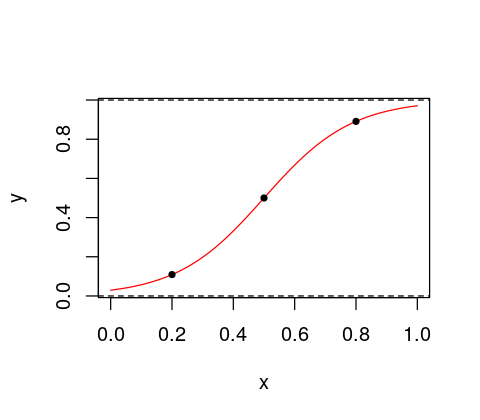

In [2]:
#### Generating the synthetic dataset ####
sigfun <- function(x) return(1/(1+exp(-7*(x-0.5))))
x <- seq(0, 1, 0.001)
y <- sigfun(x)
# function to split data in training and test sets
DoE <- splitDoE(x, y, DoE.idx = c(201, 501, 801))

options(repr.plot.width = 4, repr.plot.height = 3.5) # size of the plot
plot(x, y, type = "l", col = "red")
points(DoE$xdesign, DoE$ydesign, pch = 20)
abline(h = c(-0,1), lty = 2)

## Finite-dimensional approximation of Gaussian processes

Let $Y$ be a zero-mean Gaussian process (GP) on $\mathbb{R}$ with covariance function $k$. Consider $x \in \mathcal{D}$ with compact input space $\mathcal{D} = [0, 1]$, and a set of knots $t_1, \cdots, t_m \in \mathbb{R}$. For simplicity, we will consider equally-spaced knots {$t_j = (j-1) \Delta_m$} with $\Delta_m = 1/(m-1)$, but this assumption can be relaxed. Then, define a finite-dimensional GP, denoted by $Y_m$, as the piecewise linear interpolation of $Y$ at knots $t_1, \cdots, t_m$ (Maatouk and Bay, 2017):

$$
Y_m (x) = \sum_{j=1}^{m} \xi_j \phi_j (x),
$$

where $\xi_j := Y(t_j)$, and $\phi_1 \cdots, \phi_m$ are hat basis functions given by

$$
\phi_j (x) :=
\begin{cases}
    1 - \left|\frac{x - t_j}{\Delta_m}\right| & \mbox{if } \left|\frac{x - t_j}{\Delta_m}\right| \leq 1,\\
    0 & \mbox{otherwise}.
\end{cases}
$$

## Conditioning with interpolation and inequality constraints

Consider the finite representation $Y_m$ given the interpolation and inequality constraints,

$$
    Y_m(x) = \sum_{j=1}^{m} \xi_j \phi_{j}(x), \quad \mbox{s.t.} \quad \begin{cases} Y_m(x_i) = y_i & \mbox{(interpolation conditions)}, \\ Y_m \in \mathcal{E} & \mbox{(inequality conditions)}, \end{cases}
$$

where $x_i \in \mathcal{D}$ and $y_i \in \mathbb{R}$ for $i = 1, \cdots, n$. Then, satisfying $Y_m \in \mathcal{E}$, is equivalent to satisfying only a finite number of inequality constraints,

$$
    Y_m \in \mathcal{E} \; \Leftrightarrow \; \boldsymbol{\xi} \in \mathcal{C},
$$

where $\mathcal{C}$ is a convex set of $\mathbb{R}^{m}$ and $\boldsymbol{\xi} = [\xi_1, \cdots, \xi_m]^\top$. For instance, the convex set $\mathcal{C}$ is given by

$$
\mathcal{C} = \mathcal{C}_\kappa := \begin{cases}
	\left\{\textbf{c} \in \mathbb{R}^{m}; \ \forall \ j = 1, \cdots, m \; : \; \ell \leq c_j \leq u \right\} & \mbox{if }  \kappa = 0, \\
	\left\{\textbf{c} \in \mathbb{R}^{m}; \ \forall \ j = 2, \cdots, m \; : \; c_j \geq c_{j-1} \right\} & \mbox{if } \kappa = 1,  \\
	\left\{\textbf{c} \in \mathbb{R}^{m}; \ \forall \ j = 3, \cdots, m \; : \; c_j - c_{j-1} \geq c_{j-1} - c_{j-2} \right\} & \mbox{if } \kappa = 2,
	\end{cases}
	\label{eq:convexsetKnots}
$$

which corresponds to **boundedness**, **monotonicity**, and **convexity** constraints (respectively).

For general **linear** sets of inequalities, $\mathcal{C}$ is composed by a set of $q$ inequalities of the form

$$
\mathcal{C} = \bigg\{\textbf{c} \in \mathbb{R}^{m}; \ \forall \; k = 1, \dots, q \; : \; \ell_k \leq \sum_{j = 1}^{m} \lambda_{k,j} c_j \leq u_k \bigg\},
$$

where the $\lambda_{k,j}$'s encode the linear operations, the $l_k$'s and $u_k$'s represent the lower and upper bounds. Given a design of experiment (DoE) $\textbf{x} = [x_1, \cdots, x_n]^\top$, we have matricially:

$$
    \textbf{Y}_m = [Y_m(x_1), \cdots, Y_m(x_n)]^\top  = \boldsymbol{\Phi \xi},
$$

where $\boldsymbol{\Phi}$ is the $n \times m$ matrix defined by $\boldsymbol{\Phi}_{i,j} = \phi_j (x_i)$. Let $\textbf{y} = [y_1, \cdots, y_n]^\top$ be a realization of $Y$ at points $x_1 , \cdots, x_n$. According to (López-Lopera et al., 2018), if we assuming that the vector $\boldsymbol{\xi}$ of the values at the knots is a zero-mean Gaussian vector with covariance matrix $\boldsymbol{\Gamma} = (k(t_i,t_j))_{1 \leq i,j \leq m}$, then the distribution of $\boldsymbol{\xi}$ given both interpolation and inequality conditions is truncated multinormal:

$$
	\boldsymbol{\xi} \sim \mathcal{N} (\textbf{0}, \boldsymbol{\Gamma}) \quad \mbox{s.t.} \quad  \begin{cases} \boldsymbol{\Phi \xi} = \textbf{y} & \mbox{(interpolation conditions)}, \\ \boldsymbol{\xi} \in \mathcal{C} & \mbox{(inequality conditions)}. \end{cases}
$$

Finally, one can note that quantifying uncertainty on $Y_m$ relies on simulating $\boldsymbol{\xi} | \{\boldsymbol{\Phi \xi} = \textbf{y}, \boldsymbol{\xi} \in \mathcal{C}\}$. This is done via MC/MCMC algorithms for truncated multinormals (López-Lopera et al., 2018).

### <font color='blue'> Toy example: Sigmoid function (under inequality constraints)</font>

Now, revisiting the Sigmoid example, we need to define some arguments for the implementation of the "lineqGP" model:

1. The class of the model: ```"lineqGP"```.
2. The interpolation points: $(x_i,y_i)$ for $i = 1, \cdots, n$.
3. The type of inequality constraint: e.g. ```"boundedness"```, ```"monotonicity"``` or ```"convexity"```.
    - If ```constrType == "boundedness"```, we can define the bounds: ```bounds <- c(0,1)```.
4. The type of the sampler (Hamiltonian Monte Carlo, HMC, is performed by default): ```model$localParam$sampler <- "HMC"```
5. We can fix the number of knots $m$ from the object of the model: ```model$localParam$m```.

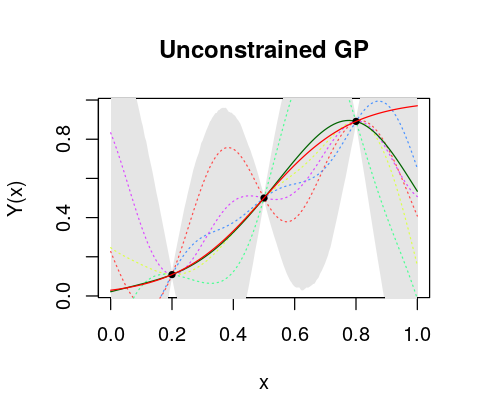

In [3]:
#### GP with inactive boundedness constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = "boundedness")
model$localParam$m <- 100 # changing the (default) number of knots
model$bounds <- c(-10,10) # changing the (default) bounds
# sampling from the model
sim.model <- simulate(model, nsim = 1e3, seed = 1, xtest = DoE$xtest)
# plotting samples
options(repr.plot.width = 4, repr.plot.height = 3.5) # size of the plot
plotLineqGPModel <- plot(sim.model, xlab = "x", ylab = "Y(x)",
                         ylim = range(y), main = "Unconstrained GP")
lines(x, y, col = "red")

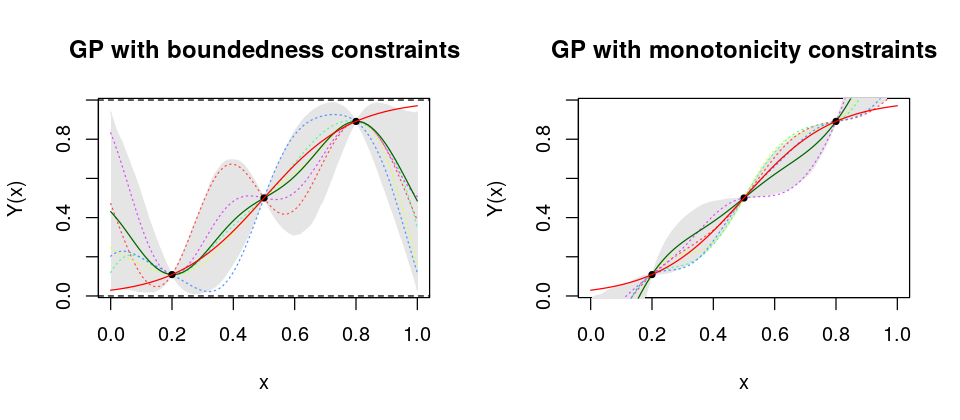

In [4]:
#### GP with active boundedness constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = "boundedness")
model$localParam$m <- 100 # changing the (default) number of knots
model$bounds <- c(0,1) # changing the (default) bounds
# sampling from the model
sim.model <- simulate(model, nsim = 1e3, seed = 1, xtest = DoE$xtest)
# plotting samples
options(repr.plot.width = 8, repr.plot.height = 3.5) # size of the plot
par(mfrow = c(1,2))
plotLineqGPModel <- plot(sim.model,  bounds = c(model$bounds),
                         xlab = "x", ylab = "Y(x)", ylim = range(y),
                         main = "GP with boundedness constraints")
lines(x, y, col = "red")

#### GP with monotonicity constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = "monotonicity")
model$localParam$m <- 100 # changing the (default) number of knots
# sampling from the model
sim.model <- simulate(model, nsim = 1e2, seed = 1, xtest = DoE$xtest)
# plotting samples
plotLineqGPModel <- plot(sim.model, xlab = "x", ylab = "Y(x)",
                         main = "GP with monotonicity constraints",
                         ylim = range(y))
lines(x, y, col = "red")

### <font color='blue'> Toy example: Sigmoid function (under multiple inequality constraints)</font>

We can impose **multiple** constraints by stacking them: ```model$constrType = c("boundedness", "monotonicity")``` (**Note:** matrices with inequality equations are stacking by rows).

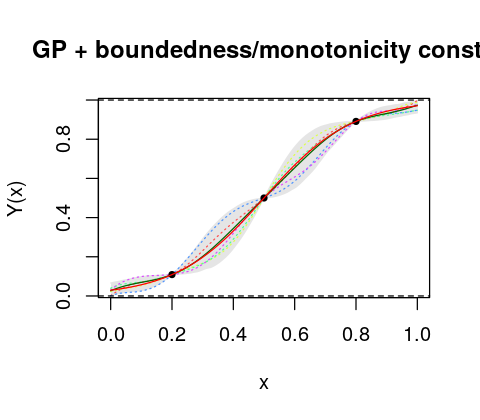

In [5]:
#### GP with both boundedness and monotonicity constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = c("boundedness", "monotonicity"))
model$localParam$m <- 100  # changing the (default) number of knots
# modifying bounds for first arg of "constrType" (boundedness)
model$bounds[1,] <- c(0,1)
# sampling from the model
sim.model <- simulate(model, nsim = 1e2, seed = 1, xtest = DoE$xtest)
# plotting samples
options(repr.plot.width = 4, repr.plot.height = 3.5) # size of the plot
plotLineqGPModel <- plot(sim.model, bounds = c(model$bounds[1,]),
                             xlab = "x", ylab = "Y(x)", ylim = range(y),
                             main = "GP + boundedness/monotonicity constr.")
lines(x, y, col = "red")

### <font color='blue'> Toy example: Sigmoid function (under linear inequality constraints)</font>

Or we can also design the linear inequality constraints by building the linear set of inequalities 

$$\textbf{l} \leq \boldsymbol{\Lambda} \boldsymbol{\xi} \leq \textbf{u},$$

where $\boldsymbol{\Lambda}$ encodes the linear operations between the knots, the $\textbf{l}$ and $\textbf{u}$ represent the lower and upper bounds (respectively). For example, for the sigmoid function, we would like to impose monotonicity constraints in the first 50 knots, and boundedness constraints $Y_m \in [0.5, 1]$ over the last 50 knots. Then, the set of inequalities are given by 

$$
\boldsymbol{\Lambda} = \begin{bmatrix} \boldsymbol{\Lambda}_M & \textbf{0} \\ \textbf{0} & \boldsymbol{\Lambda}_B \end{bmatrix}, \qquad \textbf{l} = \begin{bmatrix} \textbf{l}_M \\ \textbf{l}_B \end{bmatrix}, \qquad \textbf{u} = \begin{bmatrix} \textbf{u}_M \\ \textbf{u}_B \end{bmatrix},
$$

where

$$
\underbrace{\begin{bmatrix} -\infty \\ 0 \\ \vdots \\ 0 \end{bmatrix}}_{\textbf{l}_M} \leq \underbrace{\begin{bmatrix} 1 & 0 & \cdots & 0 & 0 \\ -1 & 1 & \cdots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \cdots & -1 & 1 \end{bmatrix}}_{\boldsymbol{\Lambda}_M} \leq \underbrace{\begin{bmatrix} \infty \\ \infty \\ \vdots \\ \infty \end{bmatrix}}_{\textbf{u}_M},
\quad \text{and} \quad
\underbrace{\begin{bmatrix} 0.5 \\ 0.5 \\ \vdots \\ 0.5 \end{bmatrix}}_{\textbf{l}_B} \leq \underbrace{\begin{bmatrix} 1 & 0 & \cdots & 0 & 0 \\ 0 & 1 & \cdots & 0 & 0 \\ \vdots & \vdots & \ddots & \vdots & \vdots \\ 0 & 0 & \cdots & 0 & 1 \end{bmatrix}}_{\boldsymbol{\Lambda}_B} \leq \underbrace{\begin{bmatrix} 1 \\ 1 \\ \vdots \\ 1 \end{bmatrix}}_{\textbf{u}_B}.
$$

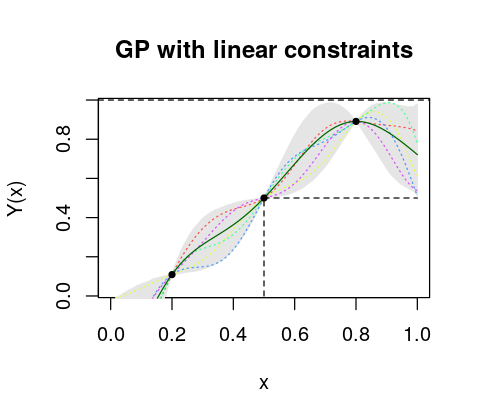

In [6]:
#### GP with both linear constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = "linear")
m <- model$localParam$m <- 100 # changing the (default) number of knots

## building the linear inequality constraints
# imposing monotonicity constraints for 50 knots
lsys1 <- lineqGPSys(m = 50, constrType = "monotonicity",
                    l = 0, u = Inf, rmInf = FALSE)
# imposing boundedness constraints $Y_m \in (0.5,1)$ for 50 knots
lsys2 <- lineqGPSys(m = 50, constrType = "boundedness",
                    l = 0.5, u = 1, rmInf = FALSE)

# stacking the constraints such that monotonocity constraints are
## imposed for the first 50 knots and boundedness constraints for
## the last 50 knots
A <- matrix(0, m, m)
A[1:(m/2), 1:(m/2)] <- lsys1$A
A[(m/2+1):m, (m/2+1):m] <- lsys2$A
# passing the inequalities to the model
model$Lambda <- A
model$lb <- c(lsys1$l, lsys2$l)
model$ub <- c(lsys1$u, lsys2$u)

# sampling from the model
sim.model <- simulate(model, nsim = 1e3, seed = 1, xtest = DoE$xtest)
# plotting samples
plotLineqGPModel <- plot(sim.model, bounds = c(-Inf, 1), xlab = "x",
                         ylab = "Y(x)", ylim = range(y),
                         main = "GP with linear constraints")
lines(c(0.5, 1), c(0.5, 0.5), lty = 2)
lines(c(0.5, 0.5), c(0, 0.5), lty = 2)

One can note that the inequality constraints can be imposed if and only if they are satisfied by the interpolation points $y_i$ for $i = 1, \cdots, n$. However, we can add a noise variance within the model ```model$varnoise``` in order to relax the interpolation constraints.

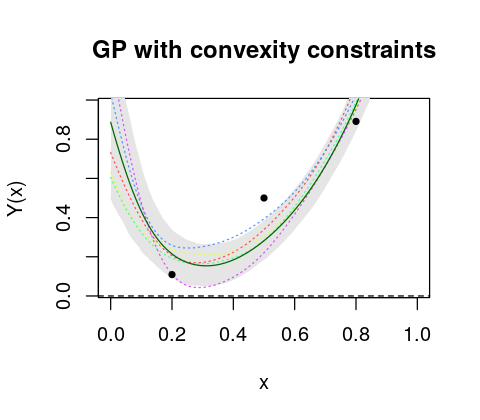

In [7]:
#### GP with both boundedness and monotonicity constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = "convexity")
model$localParam$m <- 100 # changing the (default) number of knots
model$varnoise <- 5e-3 # adding the noise variance
# sampling from the model
sim.model <- simulate(model, nsim = 1e3, seed = 1, xtest = DoE$xtest)
# plotting samples
plotLineqGPModel <- plot(sim.model, bounds = c(model$bounds[1,]),
                           xlab = "x", ylab = "Y(x)", ylim = range(y),
                           main = "GP with convexity constraints")

## Parameter estimation via maximum likelihood (ML) and constrained ML (cML)

Let $\{k_{\boldsymbol{\theta}}; \boldsymbol{\theta} \in \boldsymbol{\Theta}\}$, with $\boldsymbol{\Theta} \subset \mathbb{R}^p$, be a parametric family of covariance functions. We assume here that the zero-mean GP $Y$ has covariance function $k_{\boldsymbol{\theta}^\ast}$ for an unknown $\boldsymbol{\theta}^\ast \in \boldsymbol{\Theta}$. We consider the problem of estimating $\boldsymbol{\theta}^\ast$. Commonly, $\boldsymbol{\theta}^\ast$ is estimated by maximising the unconstrained Gaussian likelihood $p_{\boldsymbol{\theta}}(\boldsymbol{Y}_m)$ with respect to $\boldsymbol{\theta} \in \boldsymbol{\Theta}$ (maximum likelihood, ML), with $\boldsymbol{Y}_m = [Y_m(x_1), \cdots, Y_m(x_n)]^\top$. Let $\mathcal{L}_{m}(\boldsymbol{\theta})$ be the log likelihood of $\boldsymbol{\theta}$

$$
	\mathcal{L}_{m}(\boldsymbol{\theta}) =  \log p_{\boldsymbol{\theta}}(\boldsymbol{Y}_m) = - \frac{1}{2} \log (\det (\boldsymbol{K}_{\boldsymbol{\theta}})) - \frac{1}{2} \boldsymbol{Y}_m^\top \boldsymbol{K}_{\boldsymbol{\theta}}^{-1} \boldsymbol{Y}_m - \frac{n}{2} \log 2 \pi,
$$

with $\boldsymbol{K}_{\boldsymbol{\theta}} = \boldsymbol{\Phi} \boldsymbol{\Gamma}_{\boldsymbol{\theta}} \boldsymbol{\Phi}^\top$ and $\boldsymbol{\Gamma}_{\boldsymbol{\theta}} = (k_{\boldsymbol{\theta}}(t_i,t_j))_{1 \leq i,j \leq m}$. Then, the ML estimator (MLE) is

$$
\widehat{\boldsymbol{\theta}}_{\text{MLE}} = \operatorname{\arg \max}\limits_{\boldsymbol{\theta} \in \boldsymbol{\Theta}} \ \mathcal{L}_{m}(\boldsymbol{\theta}).
$$

When we maximise the likelihood $\mathcal{L}_{m}$, we are looking for a parameter $\boldsymbol{\theta}$ that improves the ability of our model to explain the data. However, because the unconstrained ML itself does not take into account the constraints $\boldsymbol{\xi} \in \mathcal{C}$, the estimated $\widehat{\boldsymbol{\theta}}_{\text{MLE}}$ may produce less realistic models. Here, we suggest to use the constrained likelihood. Let $p_{\boldsymbol{\theta}}(\boldsymbol{Y}_m| \boldsymbol{\xi} \in \mathcal{C})$ be the conditional probability density function of $\boldsymbol{Y}_m$ given $\boldsymbol{\xi} \in \mathcal{C}$, when $Y$ has covariance function $k_{\boldsymbol{\theta}}$. By using Bayes' theorem, the constrained log likelihood $\mathcal{L}_{\mathcal{C},m}(\boldsymbol{\theta}) = \log p_{\boldsymbol{\theta}}(\boldsymbol{Y}_m|\boldsymbol{\xi} \in \mathcal{C})$ is

$$
\mathcal{L}_{\mathcal{C},m}(\boldsymbol{\theta})
    = \log p_{\boldsymbol{\theta}}(\boldsymbol{Y}_m) + \log P_{\boldsymbol{\theta}}(\boldsymbol{\xi} \in \mathcal{C}|\boldsymbol{\Phi} \boldsymbol{\xi} = \boldsymbol{Y}_m) - \log P_{\boldsymbol{\theta}}(\boldsymbol{\xi} \in \mathcal{C}),
$$

where the first term is the unconstrained log-likelihood, and the last two terms depend on the inequality constraints. Then, the constrained ML (cML) estimator is given by

$$
	\widehat{\boldsymbol{\theta}}_{\text{cMLE}} = \operatorname{\arg \max}\limits_{\boldsymbol{\theta} \in \boldsymbol{\Theta}}  \mathcal{L}_{\mathcal{C},m}(\boldsymbol{\theta}).
$$

Notice that $P_{\boldsymbol{\theta}}(\boldsymbol{\xi} \in \mathcal{C} |\boldsymbol{\Phi} \boldsymbol{\xi} = \boldsymbol{Y}_m)$ and $P_{\boldsymbol{\theta}}(\boldsymbol{\xi} \in \mathcal{C})$ are Gaussian orthants. As they have no explicit expressions, numerical procedures have been implemented (López-Lopera et al., 2018).

### <font color='blue'> Toy example: Sigmoid function (covariance parameter estimation) </font>

Finally, we can estimate the covariance parameter via maximum (log)-likelihood (```"logLik"```). Inequality constraints can be taken into account into the MLE using ```add.constr = TRUE```.

**Note:** Estimation of the covariance parameter via cML is expensive since Gaussian orthant probabilities have to be estimated via Monte-Carlo. It also yields to numerical instabilities. According to (Bachoc et al., 2018), when the number of observations is large enough, we suggest the use of the standard ML for a trade-off between speed and estimation accuracy. For a small number of observations, maximising the cML provides more accurate estimators.

Initial covariance parameters: 1, 0.2
Checking gradients of objective function.
Derivative checker results: 0 error(s) detected.

  eval_grad_f[ 1 ] =  1.077893e+00 ~  1.077893e+00   [6.146900e-09]
  eval_grad_f[ 2 ] = -3.606823e+00 ~ -3.606824e+00   [5.225424e-08]


Estimated covariance parameters via MLE: 0.267051022226662, 0.3


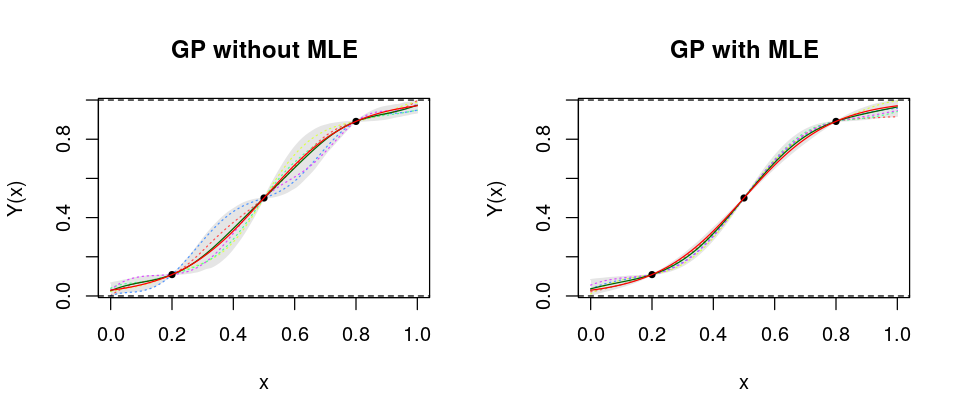

In [8]:
set.seed(7)

#### GP with both boundedness and monotonicity constraints ####
# creating the "lineqGP" model
model <- create(class = "lineqGP", x = DoE$xdesign, y = DoE$ydesign,
                constrType = c("boundedness", "monotonicity"))
model$localParam$m <- 100 # changing the (default) number of knots
# modifying the bounds for first arg of "constrType" (boundedness)
model$bounds[1,] <- c(0,1)
# sampling from the model
sim.model <- simulate(model, nsim = 1e2, seed = 1, xtest = DoE$xtest)
# plotting results
message("Initial covariance parameters: ", model$kernParam$par[1], ", ",
        model$kernParam$par[2])
options(repr.plot.width = 8, repr.plot.height = 3.5) # size of the plot
par(mfrow = c(1,2))
plotLineqGPModel <- plot(sim.model, bounds = c(model$bounds[1,]),
                         xlab = "x", ylab = "Y(x)", ylim = range(y),
                         main = "GP without MLE")
lines(x, y, col = "red")

# estimating the covariance parameter via MLE
model2 <- lineqGPOptim(model,
                       x0 = model$kernParam$par,
                       eval_f = "logLik",
                       add.constr = FALSE,
                       mcmc.opts = list(probe = "Genz", nb.mcmc = 1e4),
                       opts = list(algorithm = "NLOPT_LD_MMA",
                                   print_level = 0,
                                   ftol_abs = 1e-3,
                                   maxeval = 20,
                                   check_derivatives = TRUE,
                                   parfixed = c(FALSE, FALSE)),
                       lb = c(0.1, 0.01),
                       ub = c(2, 0.3))
message("Estimated covariance parameters via MLE: ", model2$kernParam$par[1],
        ", ", model2$kernParam$par[2])

# evaluating the "optimal" model
sim.model2 <- simulate(model2, nsim = 1e2, seed = 1, xtest = DoE$xtest)
# plotting results
plotLineqGPModel <- plot(sim.model2, bounds = c(model$bounds[1,]),
                         xlab = "x", ylab = "Y(x)", ylim = range(y),
                         main = "GP with MLE")
lines(x, y, col = "red")
## note: covariance parameters can be estimated via constrained MLE by
## setting "add.constr = TRUE", but it takes some minutes. Please be
## patient if you run it.

## More toy examples:

Other toy examples have been implemented in the documentation of the "lineqGPR" package:

1. See: ```help("lineqGPR-package")```.
2. See: ```demo(package="lineqGPR")```.
3. See also the examples of the inner functions of the package.

# 2D Gaussian process modelling with inequality constraints

The finite-dimensional Gaussian representation can be extended to $d$ dimensional input spaces by tensorisation. For readability, we focus on the case $d=2$ with $\mathcal{D} = [0, 1]^2$ and $m_1 \times m_2$ knots located on a regular grid. Then, the finite approximation is given by

$$
    Y_{m_1,m_2}(x_1,x_2) := \sum_{j_1 = 1}^{m_1} \sum_{j_2 = 1}^{m_2} \xi_{j_1,j_2} \phi_{j_1}^{1}(x_1) \phi_{j_2}^{2}(x_2), \ \mbox{s.t.} \ \begin{cases} Y_{m_1,m_2}\left(x_1^{i},x_2^{i}\right) = y_i, \; {(i = 1, \cdots, n)}\\ \xi_{j_1,j_2} \in \mathcal{C}, \end{cases}
$$

where $\xi_{j_1,j_2} = Y(t_{j_1},t_{j_2})$, $\phi_{j_1}^1$ and $\phi_{j_2}^2$ are hat basis functions, and $(x_1^1, x_2^1), \cdots, (x_1^n, x_2^n)$ constitute a design of experiment. Following a similar procedure as made for 1D, we observe that $\boldsymbol{\xi} = [\xi_{1,1}, \cdots, \xi_{1,m2}, \cdots, \xi_{m1,1}, \cdots,  \xi_{m1,m2} ]^\top$ is a zero-mean Gaussian vector with covariance matrix $\boldsymbol{\Gamma}$. Notice that each row of the matrix $\boldsymbol{\Phi}$ is given by
$$
	\boldsymbol{\Phi}_{i,:} = \begin{bmatrix} \phi_{1}^1(x_1^i) \phi_{1}^2(x_2^i) & \cdots & \phi_{1}^1(x_1^i) \phi_{m_2}^2(x_2^i) & \cdots & \phi_{m_1}^1(x_1^i) \phi_{1}^2(x_2^i) & \cdots & \phi_{m_1}^1(x_1^i) \phi_{m_2}^2(x_2^i) \end{bmatrix},
$$

for $i = 1, \cdots, n$. Finally, the posterior distribution of $\boldsymbol{\xi}|\{\boldsymbol{\Phi \xi} = \textbf{y}, \boldsymbol{\xi} \in \mathcal{C}\}$ can be computed as in (López-Lopera et al., 2018).

In [9]:
library("plot3D")
library("lineqGPR")
library("viridis")
library("DiceDesign")

rm(list=ls())
set.seed(7)

# test points for both examples.
ntest <- 30
xtest  <- as.matrix(expand.grid(seq(0, 1, length = ntest),
                                seq(0, 1, length = ntest)))
#### 2D toy examples with boundedness constraints ####
#### 2D Boundedness constraints ####
## Synthetic data ##
targetFunB <- function(x) return(0.5*(-sin(9*x[,1]) + cos(9*x[,2])))
# DoE for training points
xdesignB <- maximinSA_LHS(lhsDesign(15, 2, seed = 7)$design)$design
# adding corners for training DoE
xdesignB <- rbind(xdesignB, factDesign(2, 2)$design)
ydesignB <- targetFunB(xdesignB)

## Constrained model ##
# creating the model
modelB <- create(class = "lineqGP", x = xdesignB, y = ydesignB,
                 constrType = "boundedness")
modelB$localParam$m <- 10 # number of knots per each dimension
modelB$bounds <- c(lower = -1, upper = 1) # changing the (default) bounds
# changing the (default) covariance parameters
modelB$kernParam$par <- c(sigma2 = 1^2, theta = 0.2)
# simulating samples from the model
sim.modelB <- simulate(modelB, nsim = 1e2, seed = 7, xtest = xtest)

#### 2D Monotonicity constraints ####
#### Synthetic data ####
targetFunM <- function(x) return(atan(5*x[,1]) + atan(1*x[,2]))
# DoE for training points
xdesignM <- maximinSA_LHS(lhsDesign(12, 2, seed = 7)$design)$design
# adding corners for training DoE
xdesignM <- rbind(xdesignM, factDesign(2, 2)$design)
ydesignM <- targetFunM(xdesignM)

#### Constrained model ####
# creating the model
modelM <- create(class = "lineqGP", x = xdesignM, y = ydesignM,
                 constrType = "monotonicity")
modelM$localParam$m <- 10 # number of knots per each dimension
# changing the (default) bounds
modelM$kernParam$par <- c(sigma2 = 1^2, theta = 0.2)
# simulating samples from the model
sim.modelM <- simulate(modelM, nsim = 1e2, seed = 7, xtest = xtest)

Loading required package: viridisLite


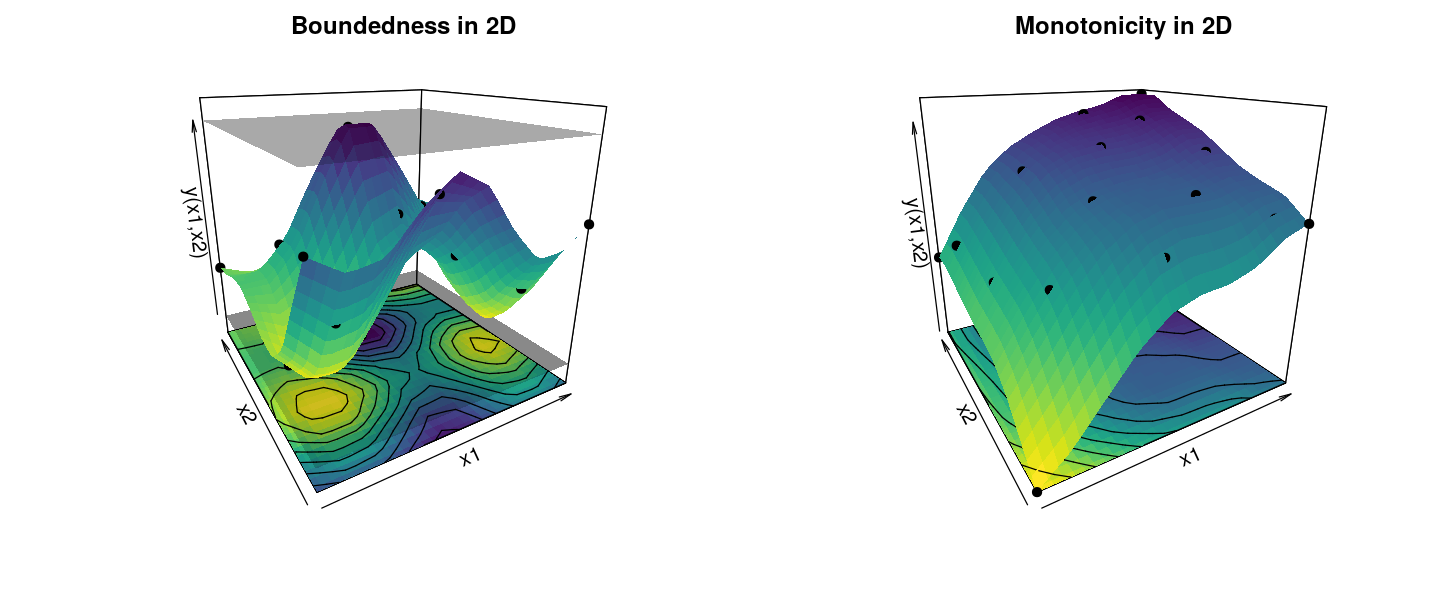

In [10]:
# plotting 2D results
par(mfrow = c(1,2))
options(repr.plot.width = 12, repr.plot.height = 5)

# plotting the results of the 2D bounded example
colormap <- rev(viridis(1e2))
p <- persp3D(x = seq(0, 1, length = ntest), y = seq(0, 1, length = ntest),
             z = matrix(sim.modelB$Phi.test%*%sim.modelB$xi.map, nrow = ntest),
             xlab = "x1", ylab = "x2", zlab = "y(x1,x2)", zlim = c(-1.2,1.2),
             main = "Boundedness in 2D", phi = 20, theta = -30, col = colormap,
             alpha = 1, colkey = FALSE, image = TRUE, contour = TRUE)
image3D(x = seq(0, 1, length = 10), y = seq(0, 1, length = 10),
        z = modelB$bounds[1], phi = 20, theta = -30, col = "black",
        alpha = 0.1, add = TRUE)
image3D(x = seq(0, 1, length = 10), y = seq(0, 1, length = 10),
        z = modelB$bounds[2], phi = 20, theta = -30, col = "black",
        alpha = 0.1, add = TRUE)
points3D(x = xdesignB[,1], y = xdesignB[,2], z = ydesignB, col = "black",
         pch = 19, cex = 1.0, add = TRUE)

# plotting the results of the 2D monotonic example
colormap <- rev(viridis(1e2))
p <- persp3D(x = seq(0, 1, length = ntest), y = seq(0, 1, length = ntest),
             z = matrix(sim.modelM$Phi.test%*%sim.modelM$xi.map, nrow = ntest), 
             xlab = "x1", ylab = "x2", zlab = "y(x1,x2)", zlim = c(0, 2.2),
             main = "Monotonicity in 2D", phi = 20, theta = -30, col = colormap,
             alpha = 1, colkey = FALSE, image = TRUE, contour = TRUE)
points3D(x = xdesignM[,1], y = xdesignM[,2], z = ydesignM, col = "black",
         pch = 19, cex = 1.0, add = TRUE)

# 2D application: nuclear safety criticality

For assessing the stability of neutron production in nuclear reactors, safety criteria based on the effective neutron multiplication factor $k_{\text{eff}}$ are commonly used. This factor is defined as the ratio of the total number of neutrons produced by a fission chain reaction to the total number of neutrons lost by absorption and leakage. Besides the geometry and composition of fissile materials (e.g. mass, density), $k_{\text{eff}}$ is sensitive to other types of parameters like the structure materials characteristics (e.g. concrete), and the presence of specific materials (e.g. moderators). Since the optimal control of an individual parameter or a combination of them can lead to safe conditions, the understanding of their influence in criticality safety assessment is crucial.

In this section, we applied the proposed framework to a dataset provided by the "Institut de Radioprotection et de Sûreté Nucléaire" (IRSN), France. The $k_{\text{eff}}$ factor was obtained from a nuclear reactor depending on two parameters of the uranium spheres: the radius $r$ and density $d$. The dataset contains 121 observations in a $11 \times 11$ grid. Notice that, on the domain considered for the input variables, $k_{\text{eff}}$ increases as the radius and density of the uranium sphere increase.

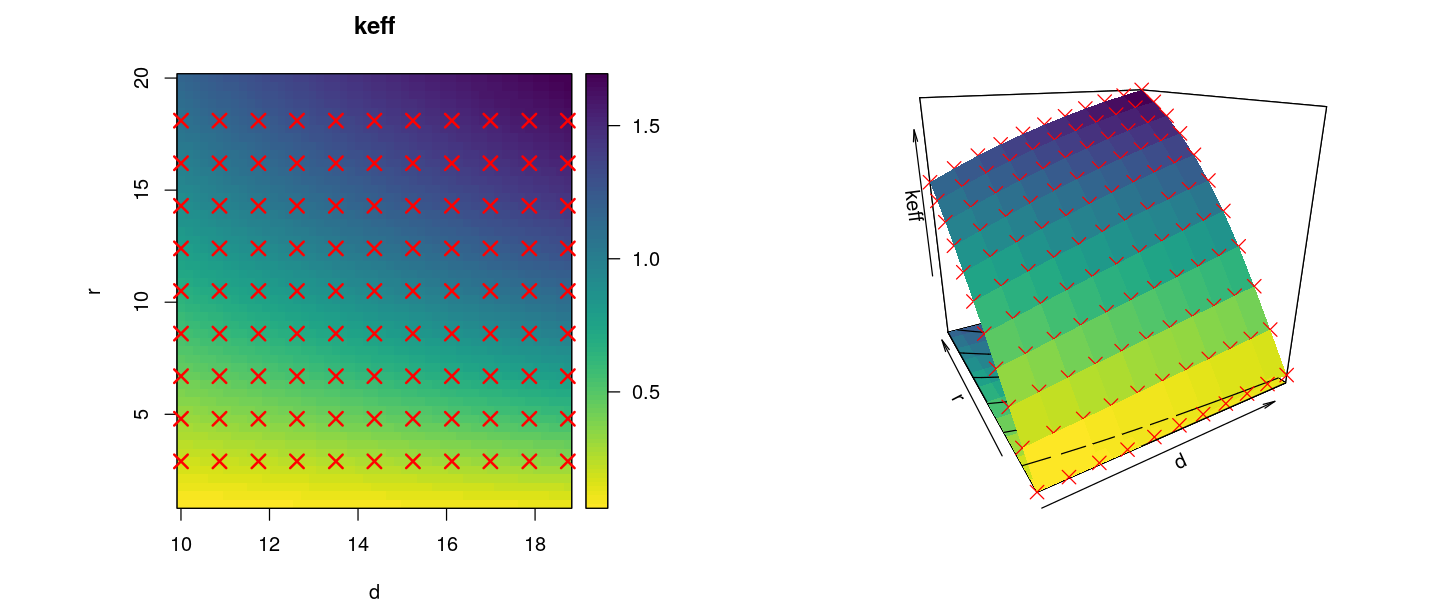

In [11]:
library("plot3D")
library("lineqGPR")
library("viridis")
library("DiceDesign")

rm(list=ls())
colormap <- rev(viridis(1e2))

#### Loading nuclear dataset ####
data <- read.csv("notebooksDocs/godiva.calculations.csv",
                 sep = ";")
data <- data[-1,] # removing the header
xgrid <- matrix(as.numeric(as.matrix(data[,c(1,2)])), ncol = 2)
ygrid <- data$mean_keff

## Plotting data ##
par(mfrow = c(1,2))
# 2D profile
options(repr.plot.width = 12, repr.plot.height = 5)
image2D(matrix(ygrid, nrow = length(unique(xgrid[,1]))), unique(xgrid[,1]),
        unique(xgrid[,2]), xlab = "d", ylab = "r", main = "keff", resfac = 5,
        col = colormap)
points(xgrid[,1], xgrid[,2], col= "red", pch = 4, cex = 1.5, lwd = 2)
# 3D profile
p <- persp3D(x = unique(xgrid[,1]), y = unique(xgrid[,2]),
             z = matrix(ygrid, nrow = length(unique(xgrid[,1]))),
             xlab = "d", ylab = "r", zlab = "keff", phi = 20, theta = -30,
             col = colormap, colkey = FALSE, image = TRUE, contour = TRUE)
points3D(x = xgrid[, 1], y = xgrid[, 2], z = ygrid, col = 'red', pch = 4,
         cex = 1.5, add = TRUE)

Here, we fit two types of GP models taking into account: (a) no constraints, and (b) both non-negativeness and monotonicity constraints. 

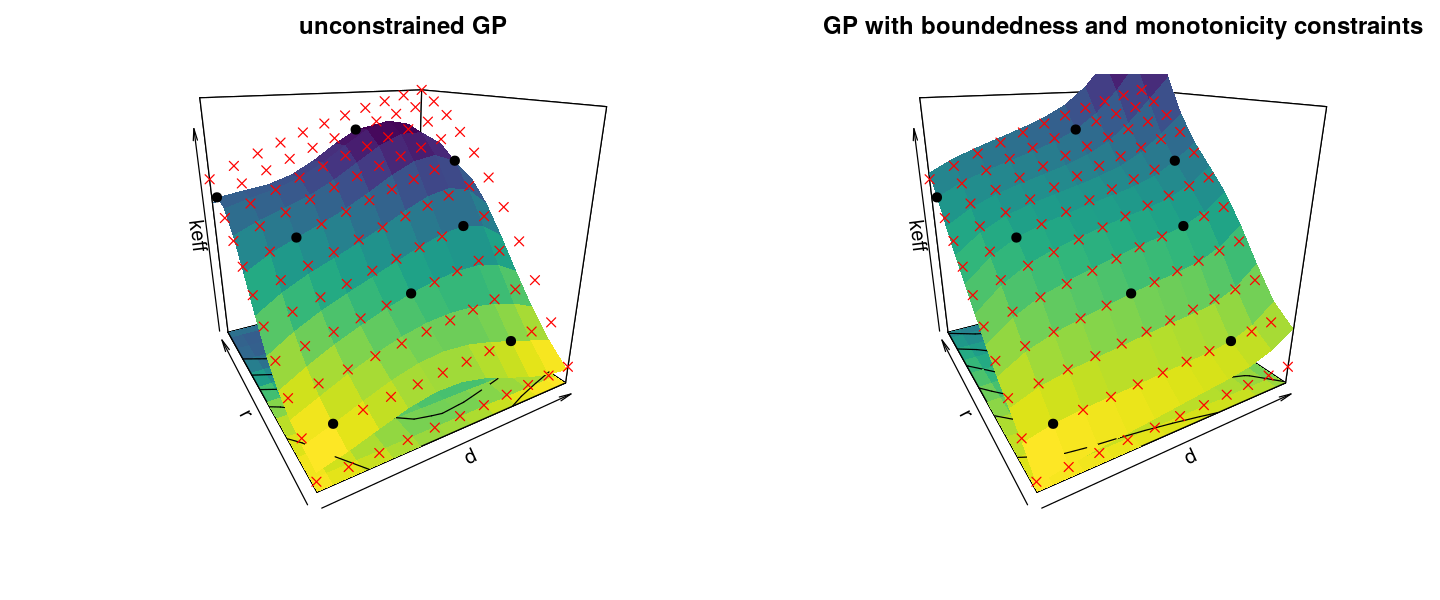

In [12]:
## scaling input space to the unit square [0,1]x[0,1]
xgrid[,1] <- (xgrid[,1] - min(xgrid[,1]))/max(xgrid[,1] - min(xgrid[,1]))
xgrid[,2] <- (xgrid[,2] - min(xgrid[,2]))/max(xgrid[,2] - min(xgrid[,2]))

## fixing points for training and test the models
idx_train <- matrix(c(c(3,7), c(9,5), c(9,2), c(6,4), c(1,10),
                      c(2,2), c(10,7), c(7,10)),
                    ncol = 2, byrow = TRUE)
idx_train <- length(unique(xgrid[,1]))*(idx_train[,2]-1) + idx_train[,1]
xtrain <- xgrid[idx_train, ]
ytrain <- ygrid[idx_train]
xtest <- xgrid[-idx_train, ]
ytest <- ygrid[-idx_train]

#### Unconstrained GP ####
modelU <- create(class = "lineqGP", x = xtrain, y = ytrain,
                 constrType = "boundedness")
modelU$localParam$m <- 10 # number of knots per each dimension
modelU$bounds <- c(lower = -10, upper = 10) # changing the (default) bounds
# changing the (default) covariance parameters
modelU$kernParam$par <- c(sigma2 = 1^2, theta1 = 0.3, theta2 = 0.3)
# simulating samples from the model
sim.modelU <- simulate(modelU, nsim = 1e2, seed = 7, xtest = xgrid)

# plotting the mean of these 100 simulations
par(mfrow = c(1,2))
p <- persp3D(x = unique(xgrid[,1]), y = unique(xgrid[,2]),
             z = matrix(rowMeans(sim.modelU$ysim),
                        nrow = length(unique(xgrid[,1]))),
             xlab = "d", ylab = "r", zlab = "keff", main = "unconstrained GP",
             zlim = c(0, max(ygrid)), phi = 20, theta = -30, col = colormap,
             colkey = FALSE, image = TRUE, contour = TRUE)
points(trans3D(x = modelU$x[,1], y = modelU$x[,2], z = modelU$y, pmat = p),
       pch = 19)
points(trans3D(x = xtest[,1], y = xtest[,2], z = ytest, pmat = p),
       col = 'red', pch = 4)


#### GP with boundedness and monotonicity constraints ####
modelC <- create(class = "lineqGP", x = xtrain, y = ytrain,
                constrType = c("boundedness", "monotonicity"))
modelC$localParam$m <- 10 # number of knots per each dimension
# modifying the bounds for first arg of "constrType" (boundedness)
modelC$bounds[1,] <- c(lower = 0, upper = Inf)
# changing the (default) covariance parameters
modelC$kernParam$par <- c(sigma2 = 1^2, theta1 = 0.3, theta2 = 0.3)
# simulating samples from the model
sim.modelC <- simulate(modelC, nsim = 1e2, seed = 7, xtest = xgrid)

# plotting the mean of these 100 simulations
p <- persp3D(x = unique(xgrid[,1]), y = unique(xgrid[,2]),
             z = matrix(rowMeans(sim.modelC$ysim),
                        nrow = length(unique(xgrid[,1]))),
             xlab = "d", ylab = "r", zlab = "keff",
             main = "GP with boundedness and monotonicity constraints",
             zlim = c(0, max(ygrid)), phi = 20, theta = -30, col = colormap,
             colkey = FALSE, image = TRUE, contour = TRUE)
points(trans3D(x = modelC$x[,1], y = modelC$x[,2], z = modelC$y, pmat = p),
       pch = 19)
points(trans3D(x = xtest[,1], y = xtest[,2], z = ytest, pmat = p),
       col = 'red', pch = 4)

Now, we estimate the covariance parameters via MLE.

Initial covariance parameters: 1, 0.3, 0.3
Estimated covariance parameters via MLE: 0.608916756280887, 0.5, 0.5


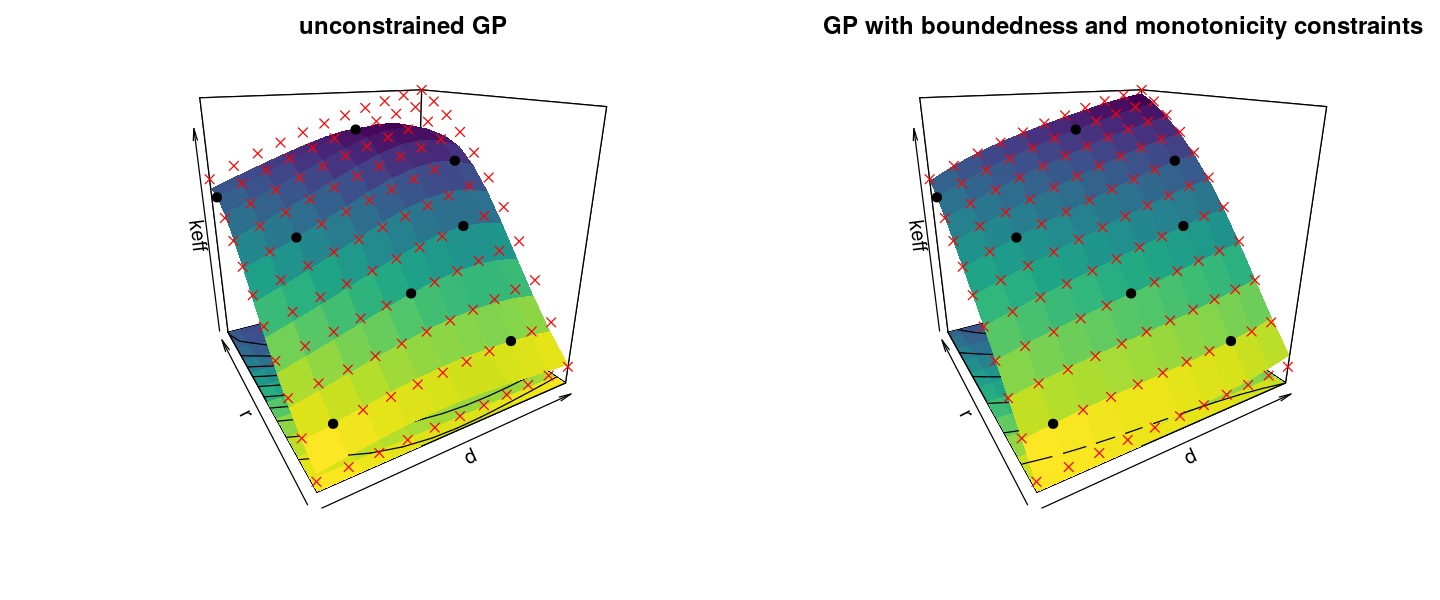

In [13]:
options(warn=-1)

#### Unconstrained GP ####
message("Initial covariance parameters: ", modelU$kernParam$par[1],
        ", ", modelU$kernParam$par[2], ", ", modelU$kernParam$par[3])
# estimating the covariance parameter via MLE for the unconstrained model
modelU2 <- lineqGPOptim(modelU,
                        x0 = modelU$kernParam$par,
                        eval_f = "logLik",
                        add.constr = FALSE,
                        lb = c(0.1, 0.01, 0.01),
                        ub = c(2, 0.5, 0.5))
message("Estimated covariance parameters via MLE: ", modelU2$kernParam$par[1],
        ", ", modelU2$kernParam$par[2], ", ", modelU2$kernParam$par[3])
# simulating samples from the model
sim.modelU2 <- simulate(modelU2, nsim = 1e2, seed = 7, xtest = xgrid)

# plotting the mean of these 100 simulations
par(mfrow = c(1,2))
p <- persp3D(x = unique(xgrid[,1]), y = unique(xgrid[,2]),
             z = matrix(rowMeans(sim.modelU2$ysim),
                        nrow = length(unique(xgrid[,1]))),
             xlab = "d", ylab = "r", zlab = "keff", main = "unconstrained GP",
             zlim = c(0, max(ygrid)), phi = 20, theta = -30, col = colormap,
             colkey = FALSE, image = TRUE, contour = TRUE)
points(trans3D(x = modelU2$x[,1], y = modelU2$x[,2], z = modelU2$y, pmat = p),
       pch = 19)
points(trans3D(x = xtest[,1], y = xtest[,2], z = ytest, pmat = p),
       col = 'red', pch = 4)

#### GP with boundedness and monotonicity constraints ####
# estimating the covariance parameter via MLE for the constrained model
modelC2 <- lineqGPOptim(modelC,
                        x0 = modelC$kernParam$par,
                        eval_f = "logLik",
                        add.constr = FALSE,
                        lb = c(0.1, 0.01, 0.01),
                        ub = c(2, 0.5, 0.5))
# simulating samples from the model
sim.modelC2 <- simulate(modelC2, nsim = 1e2, seed = 7, xtest = xgrid)

# plotting the mean of these 100 simulations
p <- persp3D(x = unique(xgrid[,1]), y = unique(xgrid[,2]),
             z = matrix(rowMeans(sim.modelC2$ysim),
                        nrow = length(unique(xgrid[,1]))),
             xlab = "d", ylab = "r", zlab = "keff",
             main = "GP with boundedness and monotonicity constraints",
             zlim = c(0, max(ygrid)), phi = 20, theta = -30, col = colormap,
             colkey = FALSE, image = TRUE, contour = TRUE)
points(trans3D(x = modelC2$x[,1], y = modelC2$x[,2], z = modelC2$y, pmat = p),
       pch = 19)
points(trans3D(x = xtest[,1], y = xtest[,2], z = ytest, pmat = p),
       col = 'red', pch = 4)